## Data sets for object detection ##
Remove image areas that do not contain objects by cropping to make the images smaller and optimize the resolution of the input images. 

In [1]:
import os
import sys
import glob
import logging
import json
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle, Polygon

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2
import computervision
from computervision.dentex import Dentex
from computervision.imageproc import ImageData
from computervision.imageproc import enclosing_box,xywh2xyxy, xyxy2xywh, clipxywh, flatten

# Print version info
print(f'Package version: {computervision.__version__}')
print(f'Python version:  {sys.version}')

Package version: v0.0.1
Python version:  3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]


In [2]:
data_dir = os.path.join(os.environ.get('HOME'), 'data')
print(f'data_dir: {data_dir}')

# Directory to store the data
dataset_dir = os.path.join(data_dir, 'dentex')

# After extraction from the .tar.gz archive, the images should be on the local fs (see the first notebook)
xrays_dir = os.path.join(dataset_dir, 'quadrant_enumeration/xrays')

# Let's make sure that we have the expected number of images available
expected_images = 634
file_list = glob.glob(os.path.join(xrays_dir, '*.png'))
print('Make sure to run the first notebook which downloads the data.')
print(f'Found {len(file_list)} images in {xrays_dir}.')

# We want to be sure that the number of images is correct before we continue
assert expected_images == len(file_list), \
    f'WARNING: expected images ({expected_images}) != images on file system ({len(file_list)})'

data_dir: /app/data
Make sure to run the first notebook which downloads the data.
Found 634 images in /app/data/dentex/quadrant_enumeration/xrays.


## Load the annotations ##

In [3]:
json_file = os.path.join(dataset_dir, 'quadrant_enumeration/train_quadrant_enumeration.json')
parquet_file_name = f'{os.path.splitext(os.path.basename(json_file))[0]}.parquet'
parquet_file = os.path.join(data_dir, parquet_file_name)
try:
    df = pd.read_parquet(parquet_file)
except Exception as e:
    print(f'ERROR: Could not load file: \n {e}')
    print('Make sure to run the first notebook which downloads the data.')
display(df.head())

,iscrowd,image_id,bbox,segmentation,id,area,category_id_1,category_id_2,height,width,file_name,quadrant,pos,fdi,ada
0,0,1,"[1283.3333333333333, 459.25925925925924, 100.0...","[[1366, 459, 1383, 662, 1380, 716, 1295, 721, ...",1,22904,0,0,1316,2710,train_283.png,1,1,11,8
1,0,1,"[1200.0, 460.18518518518516, 90.74074074074065...","[[1290, 463, 1290, 619, 1276, 719, 1224, 725, ...",2,18597,0,1,1316,2710,train_283.png,1,2,12,7
2,0,1,"[1100.9259259259259, 451.85185185185185, 119.4...","[[1162, 451, 1212, 637, 1218, 663, 1220, 679, ...",3,24808,0,2,1316,2710,train_283.png,1,3,13,6
3,0,1,"[914.8148148148148, 466.66666666666663, 174.07...","[[965, 466, 1050, 562, 1088, 709, 1088, 760, 1...",4,28017,0,4,1316,2710,train_283.png,1,5,15,4
4,0,1,"[822.2222222222222, 484.25925925925924, 182.40...","[[915, 484, 981, 671, 997, 700, 1002, 721, 100...",5,35576,0,5,1316,2710,train_283.png,1,6,16,3


### Crop images using the quadrant annotations ###
We will crop the images so that they contain the bounding boxes for the selected quadrants

In [4]:
# Function to plot an image with the bounding boxes
def plot_boxes(image, box_list, ax, label_list=None, color=None, cmap=None):
    offset_xy = (10, 80)
    # Take a ratio that looks good
    offset = (image.shape[1]*offset_xy[0]/2500,
              image.shape[0]*offset_xy[1]/1250)
    if color is None:
        # If no color is provided, color each box in a different color
        color_list = list(plt.cm.rainbow(np.linspace(0, 1, len(box_list))))
    else:
        color_list = [color]*len(box_list)
    ax.set(xticks=[], yticks=[])
    ax.imshow(image, cmap=cmap)
    # Loop over the bounding boxes
    for b, box in enumerate(box_list):
        rect = Rectangle(xy=(box[0], box[1]),
                         width=box[2],
                         height=box[3],
                         linewidth=1.5,
                         edgecolor=color_list[b],
                         facecolor='none',
                         alpha=0.7)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=box[0]+offset[0], y=box[1]+offset[1], s=label_list[b], color=color_list[b], fontsize=8)
    return ax

# Function to plot segmentations
def plot_segmentations(image, segmentation_list, ax, label_list=None, color=None, cmap=None):
    if color is None:
        # If no color is provided, use a different color for each polygon
        color_list = list(plt.cm.rainbow(np.linspace(0, 1, len(segmentation_list))))
    else:
        color_list = [color]*len(segmentation_list)
    ax.imshow(image, cmap=cmap)
    for s, seg in enumerate(segmentation_list):
        anchor = (min(seg[:, 0]), min(seg[:, 1]))
        contour = Polygon(xy=seg, 
                          linewidth=1.5, 
                          edgecolor=color_list[s],
                          facecolor=color_list[s], 
                          alpha=0.7)
        ax.add_patch(contour)
        if label_list is not None:
            ax.text(x=anchor[0], y=anchor[1], s=label_list[s], color=color_list[s])
    ax.set(xticks=[], yticks=[])
    return ax

# Create a function to build (x, y) tuples from segmentation lists
# The output of this function is an N x 2 array with polygon coordinates
def segmentation_edges(segmentation: list) -> np.ndarray:
    output = None
    try:
        assert isinstance(segmentation, list)
        assert isinstance(segmentation[0], (int, np.int64))
        assert len(segmentation) % 2 == 0
    except AssertionError as e:
        logger.error('segmentation must be a flat even-lenth list of integer values')
    else:
        seg_x = [segmentation[i] for i in range(len(segmentation)) if i % 2 == 0]
        seg_y = [segmentation[i] for i in range(len(segmentation)) if i % 2 == 1]
        output = np.array(list(zip(seg_x, seg_y)))
    return output

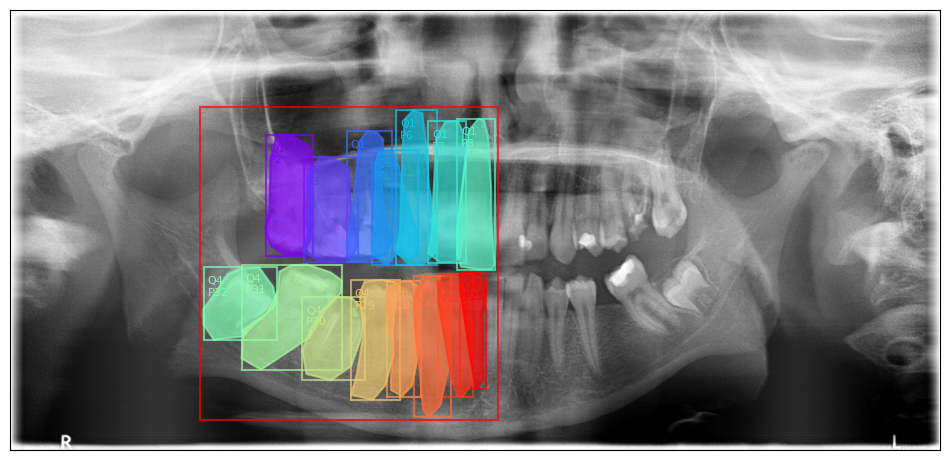

In [7]:
# Choose an image
seed = 114
rng = np.random.default_rng(seed=123)
file_name = rng.choice(a=df['file_name'].unique(), size=1)[0]
file = os.path.join(xrays_dir, file_name)
im = ImageData().load_image(file)

# Quadrants to include in the cropped image
quadrant_list = [1, 4]

# Annotations for the selected quadrants
dfq = df.loc[(df['file_name'] == file_name) & (df['quadrant'].isin(quadrant_list))]

# Get the bounding boxes and positions for these quadrants
box_list = [list(box) for box in dfq['bbox'].tolist()]
ada_list = dfq['ada'].tolist()
quad_list = dfq['quadrant'].tolist()
label_list = [f'Q{quad_list[b]}\nP{ada_list[b]}' for b in range(len(box_list))]

# Segmentations
segmentations = dfq['segmentation'].tolist()
# We need to convert this into a list of N x 2 arrays
points = [segmentation_edges(list(seg[0])) for seg in segmentations]

# Create a new bounding box that contains all of the selected bounding boxes
box = enclosing_box(bbox_list_xywh=box_list, offset=10)

# Create the figure
fig, ax = plt.subplots(figsize=(12, 6))
ax = plot_boxes(image=im, ax=ax, box_list=box_list, label_list=label_list, color=None)
ax = plot_boxes(image=im, ax=ax, box_list=[box], label_list=None, color='r')
ax = plot_segmentations(image=im, segmentation_list=points, ax=ax)

### Crop the images ###

In [16]:
# Output directory for the cropped images
output_dir = os.path.join(dataset_dir, 'cropped')
Path(output_dir).mkdir(parents=True, exist_ok=True)

# Crop the images using quadrants
quadrant_cropping_list = [[1, 2], [3, 4], [1, 4], [2, 3]]

# List of files
file_list = sorted(list(df['file_name'].unique()))
print(f'Cropping bounding boxes for these quadrants: {quadrant_cropping_list}')

Cropping bounding boxes for these quadrants: [[1, 2], [3, 4], [1, 4], [2, 3]]


In [17]:
# Save the new annotations in a list
df_cropped_list = []

# We are cropping each image using the bounding boxes that are within the quadrants
for f, file_name in enumerate(file_list):

    if (f + 1) % 100 == 0:
        print(f'Loading image {f + 1} / {len(file_list)}')

    # Load the image
    file = os.path.join(xrays_dir, file_name)
    im = ImageData().load_image(file)
    xlim, ylim = (0, im.shape[1]), (0, im.shape[0])

    # Save the name of the panoramic xray
    file_base_name = os.path.splitext(file_name)[0]
    
    # Annotations for the selected quadrants
    for quadrant_list in quadrant_cropping_list:
        
        quadrant_str = ''.join(str(q) for q in quadrant_list).zfill(2)
        quadrants = int(quadrant_str)
        
        
        dfq = df.loc[(df['file_name'] == file_name) & 
            (df['quadrant'].isin(quadrant_list))].reset_index(drop=True)

        # There might be no annotations, so we will skip the quadrant
        if len(dfq) > 0:
        
            # Bounding boxes
            box_list = [list(bb) for bb in dfq['bbox'].tolist()]
            
            # The new bounding box that is large enough to contain all of the boxes in this list
            box = enclosing_box(bbox_list_xywh=box_list, offset=10)
            
            # This box cannot be larger in any dimension than the image
            box = clipxywh(xywh=box, xlim=xlim, ylim=ylim, decimals=0)
            
            # Crop the image and save it as a grey scale PIL image
            im_cropped = im[box[1]:box[1] + box[3], box[0]:box[0] + box[2],]
            
            # Determine the limits of the cropped image
            xlim_cropped, ylim_cropped = (0, im_cropped.shape[1]), (0, im_cropped.shape[0])
            
            # We can now create the new bounding boxes for the cropped image. 
            # We can keep width and height, just change the upper left anchor point
            box_list_cropped = [[bb[0] - box[0], bb[1] - box[1], bb[2], bb[3]] for bb in box_list]
            
            # Because the new image is smaller, we need to make sure that all the bounding boxes are clipped to the dimensions of the image
            # Although here, there should be no problem because we cropped the image so that it contains all of the bounding boxes
            box_list_cropped = [clipxywh(bb, xlim=xlim_cropped, ylim=ylim_cropped, decimals=0) for bb in box_list_cropped]
            
            # Segmentations
            segmentations = dfq['segmentation'].tolist()
            
            # We need to convert this into a list of N x 2 arrays
            points = [segmentation_edges(list(seg[0])) for seg in segmentations]
            
            # We need to change the coordinates of every point to match with the cropped image
            # Using np.subtract, we can subtract a vector from each location
            points_cropped = [np.subtract(pt, [box[0], box[1]]) for pt in points]
            segmentations_cropped = [[flatten(polygon)] for polygon in points_cropped]
            
            # Save the cropped image
            file_name_cropped = f'{os.path.splitext(file_name)[0]}_{quadrant_str}.png'
            file_cropped = os.path.join(output_dir, file_name_cropped)
            # Convert the np.array into a PIL image
            # We also get rid of the RGB dimensions because these are grey scale images.
            im_pil = Image.fromarray(im_cropped).convert('L')
            im_pil.save(file_cropped)
            
            # Assemble a new data frame
            dfq_cropped = pd.DataFrame({'bbox': box_list_cropped,
                                        'segmentation': segmentations_cropped})
            
            # The new image size and file name
            dfq_cropped = dfq_cropped.assign(height=im_cropped.shape[0],
                                             width=im_cropped.shape[1],
                                             file_name=file_name_cropped,
                                             file_base_name=file_base_name,
                                             quadrants=quadrants)
            
            # Information from the original data frame
            dfq_cropped = dfq_cropped.assign(quadrant=dfq['quadrant'],
                                             pos=dfq['pos'],
                                             fdi=dfq['fdi'],
                                             ada=dfq['ada'])
        
            df_cropped_list.append(dfq_cropped)
        else:
            logger.warning(f'No annotations found for Image: {file_name}, quadrants: {quadrant_str}. Skipping.')

# Assemble the new data frame and save it
df_cropped = pd.concat(df_cropped_list, axis=0, ignore_index=True)
parquet_file_name_cropped = f'{os.path.splitext(parquet_file_name)[0]}_cropped.parquet'
parquet_file_cropped = os.path.join(output_dir, parquet_file_name_cropped)
df_cropped.to_parquet(parquet_file_cropped)

Loading image 100 / 634


No annotations found for Image: train_242.png, quadrants: 12. Skipping.


Loading image 200 / 634
Loading image 300 / 634
Loading image 400 / 634
Loading image 500 / 634


No annotations found for Image: train_614.png, quadrants: 12. Skipping.


Loading image 600 / 634


In [18]:
display(df_cropped.head())

,bbox,segmentation,height,width,file_name,file_base_name,quadrants,quadrant,pos,fdi,ada
0,"[666, 102, 103, 376]","[[757, 478, 769, 102, 678, 113, 666, 469]]",494,1473,train_0_12.png,train_0,12,1,1,11,8
1,"[593, 107, 85, 377]","[[666, 484, 678, 110, 607, 107, 604, 299, 619,...",494,1473,train_0_12.png,train_0,12,1,2,12,7
2,"[531, 69, 85, 368]","[[587, 437, 616, 357, 607, 72, 534, 69, 531, 4...",494,1473,train_0_12.png,train_0,12,1,3,13,6
3,"[457, 31, 115, 403]","[[522, 434, 572, 378, 543, 31, 463, 40, 457, 3...",494,1473,train_0_12.png,train_0,12,1,4,14,5
4,"[369, 10, 100, 406]","[[437, 416, 469, 378, 466, 10, 381, 31, 378, 2...",494,1473,train_0_12.png,train_0,12,1,5,15,4


### Verify the new data ###

Found 4 images for panoramic x-ray train_306:
['train_306_12.png', 'train_306_14.png', 'train_306_23.png', 'train_306_34.png']


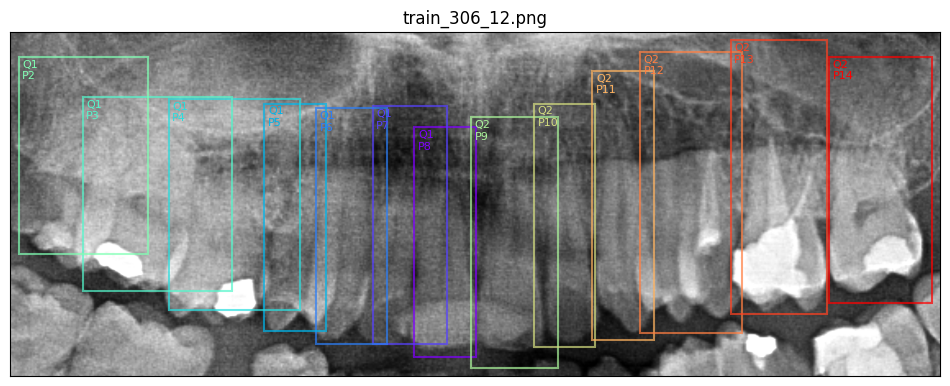

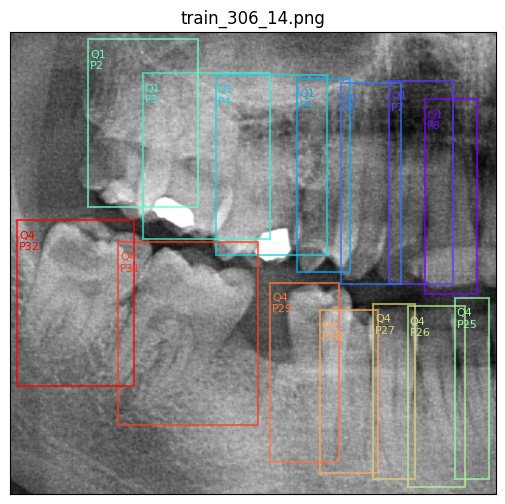

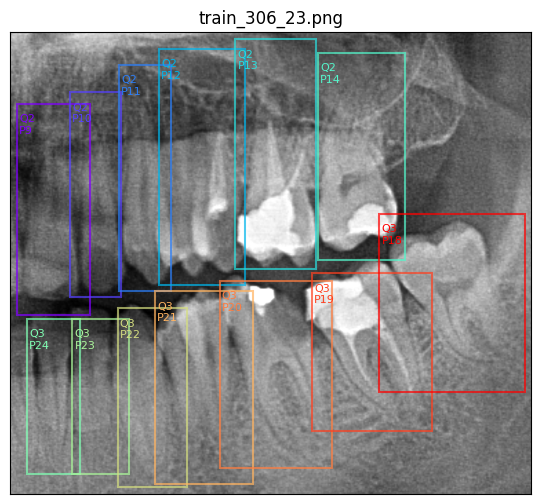

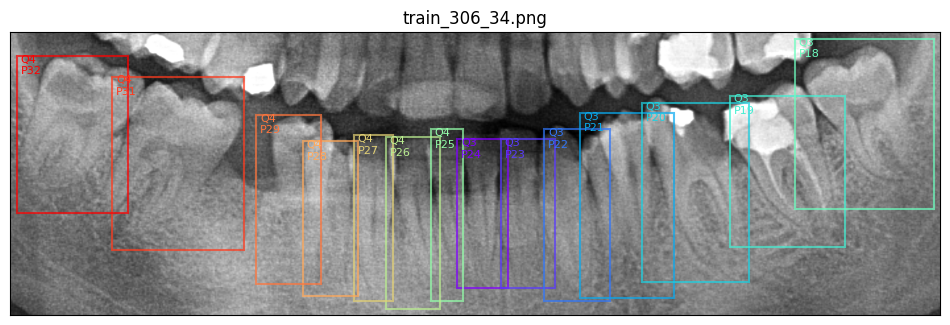

In [20]:
# Load the data frame with the new annotations
df_cropped = pd.read_parquet(parquet_file_cropped)

# Ouput directory
example_dir = os.path.join(data_dir, 'training_examples')
Path(example_dir).mkdir(parents=True, exist_ok=True)

# Check the data
rng = np.random.default_rng()
file_base_name = rng.choice(a=df_cropped['file_base_name'].unique(), size=1)[0]
# file_base_name = 'train_614'

# There should be four images combining two quadrants for each panoramic x-ray
file_name_list = sorted(list(df_cropped.loc[df_cropped['file_base_name'] == file_base_name, 'file_name'].unique()))
print(f'Found {len(file_name_list)} images for panoramic x-ray {file_base_name}:\n{file_name_list}')

for file_name in file_name_list:

    file = os.path.join(output_dir, file_name)
    im_cropped = ImageData().load_image(file)
    
    df_cropped_file = df_cropped.loc[df_cropped['file_name'] == file_name]
    
    # Get the bounding boxes and positions
    box_list = [list(box) for box in df_cropped_file['bbox'].tolist()]
    ada_list = df_cropped_file['ada'].tolist()
    quad_list = df_cropped_file['quadrant'].tolist()
    label_list = [f'Q{quad_list[b]}\nP{ada_list[b]}' for b in range(len(box_list))]
    
    # Segmentations
    segmentations = df_cropped_file['segmentation'].tolist()
    # We need to convert this into a list of N x 2 arrays
    points = [segmentation_edges(list(seg[0])) for seg in segmentations]
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 6))
    ax = plot_boxes(image=im_cropped, ax=ax, box_list=box_list, label_list=label_list, color=None, cmap='grey')
    ax.set(title=file_name)
    # ax = plot_segmentations(image=im_cropped, segmentation_list=points, ax=ax, cmap='grey')
    # Save the overlay figure
    overlay_figure_name = f'{os.path.splitext(file_name)[0]}_boxes.png'
    overlay_file = os.path.join(example_dir, overlay_figure_name)
    plt.savefig(overlay_file, bbox_inches='tight')
    plt.show()